# Feature Engineering
### Seth Adams

I found 67 repeated images after merging the train and test sets. It appears as though these images might be correctly classified for one class but then wrong for another. These repeats will be stored in a pickle for reference. See an example case in the image below.

In [29]:
#<img src="https://github.com/seth814/Machine-Learning-Collective/blob/master/images/sbs.png?raw=true" alt="drawing"/>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.sample(5)

,path,label
7936,C:\Users\Seth\Documents\Rob Campbell\train/Unk...,36
2250,C:\Users\Seth\Documents\Rob Campbell\train/Blo...,3
4106,C:\Users\Seth\Documents\Rob Campbell\train/Cop...,10
4419,C:\Users\Seth\Documents\Rob Campbell\train/Cop...,10
2845,C:\Users\Seth\Documents\Rob Campbell\train/Blo...,3


### Lets look at an example from each class

In [25]:
def plot_images(images):
    fig, axes = plt.subplots(nrows=6, ncols=6, sharex=False,
                             sharey=True, figsize=(14,14))
    fig.suptitle('Plankton (showing 36)', size=20)
    i = 0
    for x in range(6):
        for y in range(6):
            axes[x,y].imshow(images[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

n classes: 37


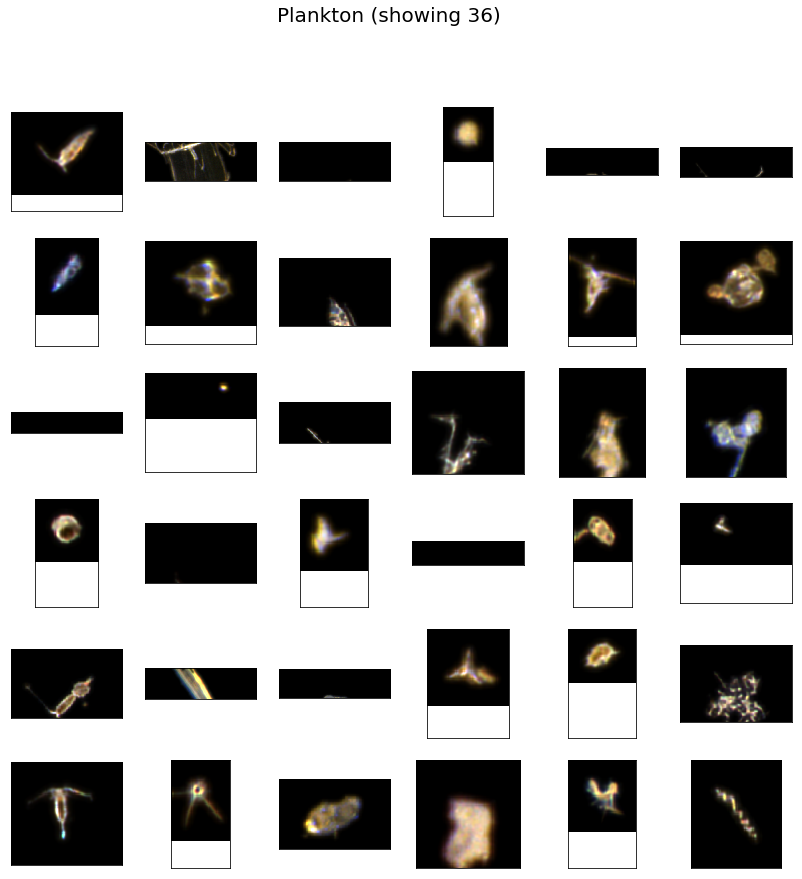

In [26]:
classes = np.unique(df_train.label)
print('n classes: {}'.format(len(classes)))

images = []
for c in classes[:len(classes)-1]:
    path = df_train[df_train.label==c].iloc[0,0]
    im = cv2.imread(path, -1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    images.append(im)

plot_images(images)
plt.show()


### Attempt to contour images